In [85]:
import jax
import jax.numpy as jnp
import numpy as np
import math
from flax import linen as nn
from flax.linen.initializers import constant, ones, zeros
import optax
from flax.training.train_state import TrainState
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns


In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Preprocessing The Data

In [3]:
df1 = pd.read_csv("hf://datasets/FrancophonIA/Fon_French_Daily_Dialogues_Parallel_Data/train.csv")

In [4]:
df1.head()

,Fon_Sentence,French_Translation
0,é ɖò ayìjúnjɔ́n,elle est assis
1,mí ɖò ayìjúnjɔ́n,nous sommes assis
2,e ɖo azɔmɛ,elle est à l'école
3,mí ɖo azɔmɛ,nous sommes à l'école
4,e ɖo xwe gbe,elle est à la maison


In [8]:
# Split on train and test
train1, test1 = train_test_split(df1, test_size=0.2, random_state=42)

In [9]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
train2 = pd.read_parquet("hf://datasets/beethogedeon/fr_fon/" + splits["train"])

In [10]:
test2 = pd.read_parquet("hf://datasets/beethogedeon/fr_fon/" + splits["test"])

In [15]:
# Instead of using .list()
fon_train1 = train1["Fon_Sentence"].tolist()
fr_train1 = train1["French_Translation"].tolist()

fon_train2 = train2["fon"].tolist()
fr_train2 = train2["french"].tolist()

# Then concatenate the lists
fon_train = fon_train1 + fon_train2
fr_train = fr_train1 + fr_train2

In [19]:
fon_test1 = test1["Fon_Sentence"].tolist()
fr_test1 = test1["French_Translation"].tolist()

fon_test2 = test2["fon"].tolist()
fr_test2 = test2["french"].tolist()

# Then concatenate the lists
fon_test = fon_test1 + fon_test2
fr_test = fr_test1 + fr_test2

Visualization

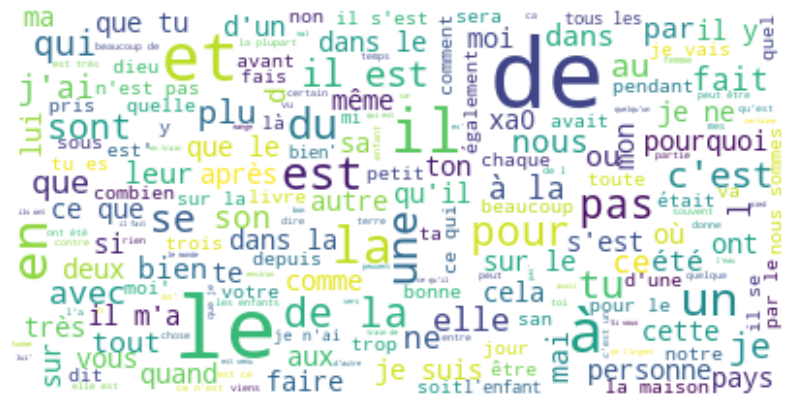

In [21]:
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate(str(fr_test))

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

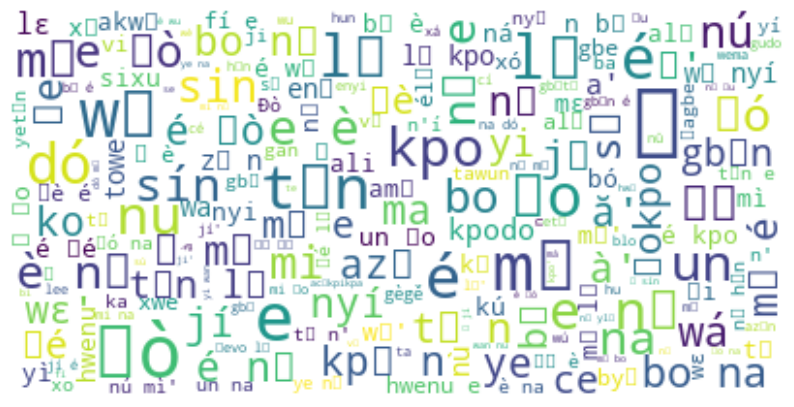

In [22]:
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate(str(fon_test))

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [23]:
for i in range(len(fon_train)):
    fon_train[i] = "sos " + str(fon_train[i]) + " eos."
    fr_train[i] = "sos " + str(fr_train[i]) + " eos."

for i in range(len(fon_test)):
    fon_test[i] = "sos " + str(fon_test[i]) + " eos."
    fr_test[i] = "sos " + str(fr_test[i]) + " eos."

In [24]:
fr = fr_train + fr_test
fon = fon_train + fon_test

Tokenization

In [25]:
# Count num of words
fr_words = []
for i in fr:
    fr_words.extend(i.split(" "))

fon_words = []
for i in fon:
    fon_words.extend(i.split(" "))

fr_words = list(set(fr_words))
fon_words = list(set(fon_words))

len_fr_words = len(fr_words)
len_fon_words = len(fon_words)

print(len_fr_words, len_fon_words)

20691 12523


Tokenization

In [28]:
tokenizer_fon = Tokenizer(num_words=len_fon_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
tokenizer_fon.fit_on_texts(fon)

word_index = tokenizer_fon.word_index
print(f"The number of words in the Fon vocabulary: {len(word_index)}")

The number of words in the Fon vocabulary: 11394


In [29]:
tokenizer_fr = Tokenizer(num_words=len_fr_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
tokenizer_fr.fit_on_texts(fr)

word_index_fr = tokenizer_fr.word_index
print(f"The number of words in the French vocabulary: {len(word_index_fr)}")

The number of words in the French vocabulary: 18395


In [30]:
# Tokenize the sequences
fon_sequences_train = tokenizer_fon.texts_to_sequences(fon_train)
fr_sequences_train = tokenizer_fr.texts_to_sequences(fr_train)

fon_sequences_test = tokenizer_fon.texts_to_sequences(fon_test)
fr_sequences_test = tokenizer_fr.texts_to_sequences(fr_test)

Padding

In [32]:
fon_sequences_train = pad_sequences(fon_sequences_train, maxlen = 30, padding='post', truncating='post')
fr_sequences_train = pad_sequences(fr_sequences_train, maxlen = 30, padding='post', truncating='post')

fon_sequences_test = pad_sequences(fon_sequences_test, maxlen = 30, padding='post', truncating='post')
fr_sequences_test = pad_sequences(fr_sequences_test, maxlen = 30, padding='post', truncating='post')


Positional Encoding

In [34]:
def get_angles(pos, i, embedding_dim):
    angle_rates = 1 / jnp.power(10000, (2 * (i//2)) / jnp.float32(embedding_dim))
    return pos * angle_rates

In [37]:
def positional_encoding(position, embedding_dim):
    angle_rads = get_angles(jnp.arange(position)[:, jnp.newaxis],
                            jnp.arange(embedding_dim)[jnp.newaxis, :], embedding_dim)
    # apply sin to even indices in the array. i.e., 2i
    angle_rads = angle_rads.at[:, 0::2].set(jnp.sin(angle_rads[..., 0::2]))
    # apply cos to odd indices in the array. i.e., 2i+1
    angle_rads = angle_rads.at[:, 1::2].set(jnp.cos(angle_rads[..., 1::2]))
    pos_encoding = angle_rads[jnp.newaxis, ...]
    return jnp.array(pos_encoding)

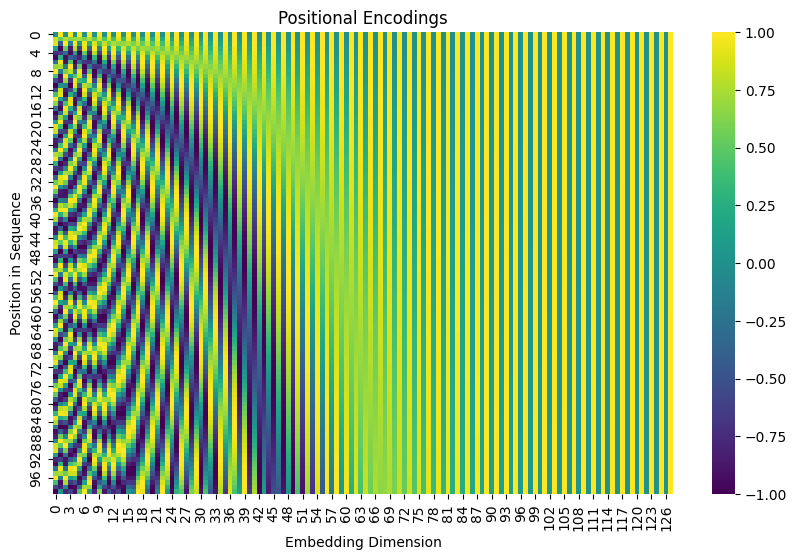

In [40]:
# Generate positional encodings
pos_encodings = positional_encoding(100, 128)

# Visualize the encodings as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pos_encodings[0], cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Encodings')
plt.show()

Masking

In [42]:
def create_padding_mask(seq):
    seq = jnp.equal(seq, 0)
    return seq[:, jnp.newaxis, jnp.newaxis, :]

In [43]:
def create_look_ahead_mask(size):
    # create a matrix with ones on the diagonal and zeros below the diagonal
    mask = 1 - jnp.triu(jnp.ones((size, size)), 1)
    return mask

In [45]:
def create_masks(inputs, targets):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inputs)
    # Decoder padding mask
    dec_padding_mask = create_padding_mask(inputs)
    # Look ahead mask for the decoder
    look_ahead_mask = create_look_ahead_mask(targets.shape[1])
    # Decoder target padding mask
    dec_target_padding_mask = create_padding_mask(targets)
    # Combined mask for the decoder
    combined_mask = jnp.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

Model Implementation

Self Attention

In [50]:
def scaled_dot_product_attention(q, k, v, mask):
    # q shape: (batch_size, num_heads, seq_len_q, depth)
    # k shape: (batch_size, num_heads, seq_len_k, depth)
    # v shape: (batch_size, num_heads, seq_len_v, depth)

    # Transpose k for the dot product
    # (batch_size, num_heads, seq_len_q, depth) @ (batch_size, num_heads, depth, seq_len_k)
    matmul_qk = jnp.einsum('bhqd,bhkd->bhqk', q, k)

    # Scale the dot product
    dk = jnp.array(k.shape[-1], dtype=jnp.float32)
    scaled_attention_logits = matmul_qk / jnp.sqrt(dk)

    # Apply mask if provided
    if mask is not None:
        # Add the mask to the scaled tensor
        scaled_attention_logits = jnp.where(mask == 0, -1e9, scaled_attention_logits)

    # Calculate attention weights
    attention_weights = jax.nn.softmax(scaled_attention_logits, axis=-1)

    # Apply attention weights to values
    # (batch_size, num_heads, seq_len_q, seq_len_k) @ (batch_size, num_heads, seq_len_v, depth)
    output = jnp.einsum('bhqk,bhkd->bhqd', attention_weights, v)

    return output, attention_weights

Multi Head Attention

In [51]:
class MultiHeadAttention(nn.Module):
    key_dim : int
    num_heads : int
    dropout_rate : float = 0.0

    def setup(self):
        assert self.key_dim % self.num_heads == 0
        self.depth = self.key_dim // self.num_heads

        # Initialize the dense layers
        self.wq = nn.Dense(self.key_dim)
        self.wk = nn.Dense(self.key_dim)
        self.wv = nn.Dense(self.key_dim)

        # Dropout layer
        self.dropout = nn.Dropout(rate=self.dropout_rate)

        # Output dense layer
        self.dense = nn.Dense(self.key_dim)

    def split_heads(self, x, batch_size):
        x = x.reshape((batch_size, -1, self.num_heads, self.depth))
        return x.transpose((0, 2, 1, 3))

    def __call__(self, q, k, v, mask=None, deterministic=True):
        batch_size = q.shape[0]

        # Dense layers on q, k, v
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # Split the heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled dot product attention

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = scaled_attention.transpose((0, 2, 1, 3))

        # Reshape and add the dense layer
        concat_attention = scaled_attention.reshape((batch_size, -1, self.key_dim))
        output = self.dense(concat_attention)
        output = self.dropout(output, deterministic=deterministic)
        return output, attention_weights


Fully Connected NeuralNetwork

In [55]:
class FeedForward(nn.Module):
    embedding_dim : int
    ff_dim : int

    def setup(self):
        self.dense1 = nn.Dense(self.ff_dim)
        self.dense2 = nn.Dense(self.embedding_dim)

    def __call__(self, x,):
        x = self.dense1(x)
        x = nn.relu(x)
        x = self.dense2(x)
        return x

Encoder

In [54]:
class DyT(nn.Module):
    """Dynamic Tanh (DyT) normalization layer.

    This layer performs normalization using a learnable scaled tanh activation
    followed by an affine transformation (weight * x + bias).

    Attributes:
        num_features: Number of features/channels to normalize
        alpha_init: Initial value for the tanh scaling parameter (default: 0.5)
    """
    num_features: int
    alpha_init: float = 0.5

    def setup(self):
        # Learnable scaling parameter for tanh activation
        self.alpha = self.param('alpha', constant(self.alpha_init), ())  # Scalar parameter

        # Affine transformation parameters (similar to BatchNorm)
        self.weight = self.param('weight', ones, (self.num_features,))    # Scale parameter
        self.bias = self.param('bias', zeros, (self.num_features,))       # Shift parameter

    def __call__(self, x):
        # Apply scaled tanh activation
        # constrains values between -1 and 1 while alpha controls steepness
        normalized = nn.tanh(self.alpha * x)

        # Apply affine transformation (channel-wise scaling and shifting)
        return normalized * self.weight + self.bias

In [56]:
class EncoderLayer(nn.Module):
    embedding_dim : int
    num_heads : int
    ff_dim : int
    dropout_rate : float = 0.1

    def setup(self):
        self.mha = MultiHeadAttention(self.embedding_dim, self.num_heads, dropout_rate=self.dropout_rate)
        self.ffn = FeedForward(self.embedding_dim, self.ff_dim)

        self.dyt1 = DyT(self.embedding_dim)
        self.dyt2 = DyT(self.embedding_dim)

        self.dropout = nn.Dropout(rate=self.dropout_rate)


    def __call__(self, x, mask, deterministic=True):
        # Multi-head attention
        attn_output, _ = self.mha(x, x, x, mask, deterministic=deterministic)

        # Add & Norm
        x = self.dyt1(x + attn_output)

        # Feedforward network
        ffn_output = self.ffn(x)
        ffn_output = self.dropout(ffn_output, deterministic=deterministic)
        # Add & Norm
        x = self.dyt2(x + ffn_output)

        return x


In [59]:
class Encoder(nn.Module):
    num_layers : int
    embedding_dim : int
    num_heads : int
    ff_dim : int
    input_vocab_size: int
    maximum_position_encoding : int
    dropout_rate : float = 0.1

    def setup(self):
        self.encoder_layers = [EncoderLayer(self.embedding_dim, self.num_heads, self.ff_dim, self.dropout_rate)
                               for _ in range(self.num_layers)]
        self.embedding = nn.Embed(self.input_vocab_size, self.embedding_dim)

        self.pos_encoding = positional_encoding(self.maximum_position_encoding, self.embedding_dim)

        self.dropout = nn.Dropout(rate=self.dropout_rate)

    def __call__(self, x, mask, deterministic=True):
        seq_len = x.shape[1]

        input_embedding = self.embedding(x)
        input_embedding *= jnp.sqrt(jnp.float32(self.embedding_dim))
        input_embedding += self.pos_encoding[:, :seq_len, :]
        input_embedding = self.dropout(input_embedding, deterministic=deterministic)

        for i in range(self.num_layers):
            x = self.encoder_layers[i](input_embedding, mask, deterministic=deterministic)

        return x

Decoder

In [70]:
class DecoderLayer(nn.Module):
    embedding_dim : int
    num_heads : int
    ff_dim : int
    dropout_rate : float = 0.1

    def setup(self):
        self.mha1 = MultiHeadAttention(self.embedding_dim, self.num_heads, dropout_rate=self.dropout_rate)
        self.mha2 = MultiHeadAttention(self.embedding_dim, self.num_heads, dropout_rate=self.dropout_rate)
        self.ffn = FeedForward(self.embedding_dim, self.ff_dim)

        self.dyt1 = DyT(self.embedding_dim)
        self.dyt2 = DyT(self.embedding_dim)
        self.dyt3 = DyT(self.embedding_dim)

        self.dropout = nn.Dropout(rate=self.dropout_rate)

    def __call__(self, x, enc_output, look_ahead_mask, padding_mask, deterministic=True):
        # Masked multi-head attention
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask, deterministic=deterministic)
        # Add & Norm
        out1 = self.dyt1(x + attn1)

        # Multi-head attention
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask, deterministic=deterministic)
        attn2 = self.dropout(attn2, deterministic=deterministic)
        # Add & Norm
        out2 = self.dyt2(out1 + attn2)

        # Feedforward network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout(ffn_output, deterministic=deterministic)
        # Add & Norm
        out3 = self.dyt3(out2 + ffn_output)

        return out3, attn_weights_block1, attn_weights_block2

In [73]:
class Decoder(nn.Module):
    num_layers: int
    embedding_dim : int
    num_heads : int
    ff_dim : int
    target_vocab_size : int
    maximum_position_encoding : int
    dropout_rate : float = 0.1

    def setup(self):
        self.embedding = nn.Embed(self.target_vocab_size, self.embedding_dim)
        self.decoder_layers = [DecoderLayer(self.embedding_dim, self.num_heads, self.ff_dim, self.dropout_rate)
                               for _ in range(self.num_layers)]
        self.pos_encoding = positional_encoding(self.maximum_position_encoding, self.embedding_dim)
        self.dropout = nn.Dropout(rate=self.dropout_rate)

    def __call__(self, x, enc_output, look_ahead_mask, padding_mask, deterministic=True):
        seq_len = x.shape[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= jnp.sqrt(jnp.float32(self.embedding_dim))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, deterministic=deterministic)

        for i in range(self.num_layers):
            x, block1, block2 = self.decoder_layers[i](x, enc_output, look_ahead_mask, padding_mask, deterministic=deterministic)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attention_weights

Transformer

In [75]:
class Transformer(nn.Module):
    num_layers: int
    embedding_dim: int
    num_heads: int
    ff_dim: int
    input_vocab_size: int
    target_vocab_size: int
    max_positional_encoding_input: int
    max_positional_encoding_target: int
    dropout_rate: float = 0.1


    def setup(self):
        self.encoder = Encoder(self.num_layers, self.embedding_dim, self.num_heads, self.ff_dim,
                               self.input_vocab_size, self.max_positional_encoding_input, self.dropout_rate)

        self.decoder = Decoder(self.num_layers, self.embedding_dim, self.num_heads, self.ff_dim,
                               self.target_vocab_size, self.max_positional_encoding_target, self.dropout_rate)

        self.final_layer = nn.Dense(self.target_vocab_size)

    def __call__(self, inputs, targets, enc_padding_mask, look_ahead_mask, dec_padding_mask, deterministic=True):
        # Encode the input sequence
        enc_output = self.encoder(inputs, enc_padding_mask, deterministic=deterministic)

        # Decode the target sequence
        dec_output, attention_weights = self.decoder(targets, enc_output, look_ahead_mask, dec_padding_mask, deterministic=deterministic)

        # Final dense layer
        logits = self.final_layer(dec_output)
        logits = nn.softmax(logits)

        return logits, attention_weights


Training

Initializing Hyperparameters

In [77]:
# Set hyperparameters for the Transformer model
embedding_dim = 256  # dimensionality of the embeddings used for tokens in the input and target sequences
fully_connected_dim = 512  # dimensionality of the hidden layer of the feedforward neural network within the Transformer block
num_layers = 4  # number of Transformer blocks in the encoder and decoder stacks
num_heads = 8  # number of heads in the multi-head attention mechanism
dropout_rate = 0.1  # dropout rate for regularization

# Set vocabulary sizes for input and target sequences
input_vocab_size = len(tokenizer_fr.word_index) + 2  # add 2 for the start and end tokens
target_vocab_size = len(tokenizer_fon.word_index) + 2  # add 2 for the start and end tokens

# Set maximum positional encoding values for input and target sequences
max_positional_encoding_input = input_vocab_size  # maximum positional encoding value for input sequence
max_positional_encoding_target = target_vocab_size  # maximum positional encoding value for target sequence

# Set the number of epochs and batch size for training
EPOCHS = 10
batch_size = 64

Learning Rate Scheduler

In [79]:
class CustomSchedule:
    def __init__(self, embedding_dim, warmup_steps=4000):
        self.embedding_dim = jnp.float32(embedding_dim)
        self.warmup_steps = jnp.float32(warmup_steps)

    def __call__(self, step):
        step = jnp.float32(step)
        arg1 = 1.0 / jnp.sqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return (1.0 / jnp.sqrt(self.embedding_dim)) * jnp.minimum(arg1, arg2)

In [80]:
# Create an instance of the custom learning rate schedule
learning_rate = CustomSchedule(embedding_dim)

In [82]:
transformer = Transformer(num_layers, embedding_dim, num_heads,
                          fully_connected_dim, input_vocab_size, target_vocab_size,
                          max_positional_encoding_input, max_positional_encoding_target, dropout_rate)

In [84]:
# Initialize the model with random weights
rng = jax.random.PRNGKey(0)
input_shape = (batch_size, 30)
target_shape = (batch_size, 30)
enc_padding_mask_shape = (batch_size, 1, 1, 30)
look_ahead_mask_shape = (batch_size, 1, 30, 30)
dec_padding_mask_shape = (batch_size, 1, 1, 30)
params = transformer.init(rng, jnp.ones(input_shape, jnp.int32), jnp.ones(target_shape, jnp.int32),
                          jnp.ones(enc_padding_mask_shape, jnp.int32), jnp.ones(look_ahead_mask_shape, jnp.int32),
                          jnp.ones(dec_padding_mask_shape, jnp.int32), deterministic=True)

In [87]:
optimizer = optax.inject_hyperparams(optax.adamw)(
        learning_rate=learning_rate,
        b1=0.9,  # changed from beta_1
        b2=0.98,  # changed from beta_2
        eps=1e-9  # changed from epsilon
)

Loss Function

In [88]:
def sparse_categorical_crossentropy(logits, labels, ignore_index=0):
    """Compute sparse categorical cross entropy loss.

    Args:
        logits: Output probabilities from model [batch_size, seq_len, vocab_size]
        labels: Target indices [batch_size, seq_len]
        ignore_index: Index to ignore in loss calculation (usually padding)

    Returns:
        Loss value
    """
    vocab_size = logits.shape[-1]

    # Convert labels to one-hot
    labels_one_hot = jax.nn.one_hot(labels, vocab_size)

    # Compute cross entropy loss
    loss = -jnp.sum(labels_one_hot * jnp.log(logits + 1e-9), axis=-1)

    # Create mask to ignore padding tokens
    mask = jnp.logical_not(jnp.equal(labels, ignore_index))

    # Apply mask and compute mean
    loss = jnp.sum(loss * mask) / jnp.sum(mask)

    return loss

In [ ]:
def accuracy_function(true_values, predictions):
    accuracies = jnp.equal(true_values, jnp.argmax(predictions, axis=2))
    mask = jnp.logical_not(jnp.equal(true_values, 0))

    accuracies = jnp.logical_and(mask, accuracies)
    return jnp.reduce_sum(accuracies) / jnp.sum(mask)